## Library Imports

In [1]:
from time import time
notebook_start_time = time()

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
from torchvision import models, transforms

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Constants and Utilities

In [3]:
SEED = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "../input/petfinder-pawpularity-score"

# Pretrained Data Transforms
TRANSFORM_PRE = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225]),
                                   ])
TRANSFORM_PRE_AUG = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225]),
                                        transforms.RandomHorizontalFlip(p=0.15),
                                        transforms.RandomVerticalFlip(p=0.15),
                                        transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.5, 1.5)),
                                       ])

# Non-pretrained Data Transforms
TRANSFORM_NOPRE = transforms.Compose([transforms.ToTensor(),])
TRANSFORM_NOPRE_AUG = transforms.Compose([transforms.ToTensor(), 
                                          transforms.RandomHorizontalFlip(p=0.15),
                                          transforms.RandomVerticalFlip(p=0.15),
                                          transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.5, 1.5)),
                                         ])

sc_y = StandardScaler()

In [4]:
def breaker(num=50, char="*") -> None:
    print("\n" + num*char + "\n")


def head(x, no_of_ele=5) -> None:
    print(x[:no_of_ele])


def get_targets(path: str) -> np.ndarray:
    df = pd.read_csv(os.path.join(path, "train.csv"), engine="python")
    targets  = df.iloc[:, -1].copy().values
    return targets


def show_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])    
    
    x_Axis = np.arange(1, len(L) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="train")
    plt.plot(x_Axis, VL, "b", label="valid")
    plt.grid()
    plt.legend()
    plt.title("MSE Loss")
    plt.show()

## Dataset Template

In [5]:
class DS(Dataset):
    def __init__(self, images=None, targets=None, transform=None):
        self.images    = images
        self.targets   = targets
        self.transform = transform
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        return self.transform(self.images[idx]), torch.FloatTensor(self.targets[idx])

## Build DataLoaders

In [6]:
def build_dataloaders(tr_images: np.ndarray, va_images: np.ndarray,
                      tr_targets: np.ndarray, va_targets: np.ndarray,
                      batch_size: int, seed: int, 
                      tr_transform=None, va_transform=None):

    breaker()
    print("Building Train and Validation DataLoaders ...")
    
    tr_data_setup = DS(images=tr_images, targets=tr_targets, transform=tr_transform)
    va_data_setup = DS(images=va_images, targets=va_targets, transform=va_transform)
    
    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(seed)),
        "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False)
    }
    
    return dataloaders

## Build Model

In [7]:
def build_model(model_name: str, pretrained: bool, HL: list, seed: int):
    class ImageModel(nn.Module):
        def __init__(self, model_name=None, pretrained=False, HL=None):
            super(ImageModel, self).__init__()

            if re.match(r"^resnet$", model_name, re.IGNORECASE):
                self.features = models.resnet50(pretrained=pretrained, progress=True)
                if pretrained:
                    self.freeze()
                self.features = nn.Sequential(*[*self.features.children()][:-1])
                self.features.add_module("Flatten", nn.Flatten())

                in_features = self.features[-3][2].bn3.num_features


            elif re.match(r"^vgg$", model_name, re.IGNORECASE):
                self.features = models.vgg16_bn(pretrained=pretrained, progress=True)
                if pretrained:
                    self.freeze()
                self.features = nn.Sequential(*[*self.features.children()][:-2])
                self.features.add_module("Adaptive Average Pool", nn.AdaptiveAvgPool2d(output_size=(2, 2)))
                self.features.add_module("Flatten", nn.Flatten())

                in_features = self.features[-3][41].num_features * 2 * 2


            elif re.match(r"^mobilenet$", model_name, re.IGNORECASE):
                self.features = models.mobilenet_v2(pretrained=pretrained, progress=True)
                if pretrained:
                    self.freeze()
                self.features = nn.Sequential(*[*self.features.children()][:-1])
                self.features.add_module("Adaptive Average Pool", nn.AdaptiveAvgPool2d(output_size=(1, 1)))
                self.features.add_module("Flatten", nn.Flatten())

                in_features = self.features[-3][-1][1].num_features


            elif re.match(r"^densenet$", model_name, re.IGNORECASE):
                self.features = models.densenet169(pretrained=pretrained, progress=True)
                if pretrained:
                    self.freeze()
                self.features = nn.Sequential(*[*self.features.children()][:-1])
                self.features.add_module("Adaptive Average Pool", nn.AdaptiveAvgPool2d(output_size=(1, 1)))
                self.features.add_module("Flatten", nn.Flatten())

                in_features = self.features[0].norm5.num_features

            self.predictor = nn.Sequential()
            if len(HL) == 0:
                self.predictor.add_module("BN1", nn.BatchNorm1d(num_features=in_features, eps=1e-5))
                self.predictor.add_module("FC1", WN(nn.Linear(in_features=in_features, out_features=1)))
            elif len(HL) == 1:
                self.predictor.add_module("BN1", nn.BatchNorm1d(num_features=in_features, eps=1e-5))
                self.predictor.add_module("FC1", WN(nn.Linear(in_features=in_features, out_features=HL[0])))
                self.predictor.add_module("AN1", nn.ReLU())
                self.predictor.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
                self.predictor.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=1)))
            elif len(HL) == 2:
                self.predictor.add_module("BN1", nn.BatchNorm1d(num_features=in_features, eps=1e-5))
                self.predictor.add_module("FC1", WN(nn.Linear(in_features=in_features, out_features=HL[0])))
                self.predictor.add_module("AN1", nn.ReLU())
                self.predictor.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
                self.predictor.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=HL[1])))
                self.predictor.add_module("AN2", nn.ReLU())
                self.predictor.add_module("BN3", nn.BatchNorm1d(num_features=HL[1], eps=1e-5))
                self.predictor.add_module("FC3", WN(nn.Linear(in_features=HL[1], out_features=1)))
            elif len(HL) == 3:
                self.predictor.add_module("BN1", nn.BatchNorm1d(num_features=in_features, eps=1e-5))
                self.predictor.add_module("FC1", WN(nn.Linear(in_features=in_features, out_features=HL[0])))
                self.predictor.add_module("AN1", nn.ReLU())
                self.predictor.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
                self.predictor.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=HL[1])))
                self.predictor.add_module("AN2", nn.ReLU())
                self.predictor.add_module("BN3", nn.BatchNorm1d(num_features=HL[1], eps=1e-5))
                self.predictor.add_module("FC3", WN(nn.Linear(in_features=HL[1], out_features=HL[2])))
                self.predictor.add_module("AN3", nn.ReLU())
                self.predictor.add_module("BN4", nn.BatchNorm1d(num_features=HL[2], eps=1e-5))
                self.predictor.add_module("FC4", WN(nn.Linear(in_features=HL[2], out_features=1)))

        def freeze(self):
            for params in self.parameters():
                params.requires_grad = False

        def get_optimizer(self, lr=1e-3, wd=0):
            params = [p for p in self.parameters() if p.requires_grad]
            return optim.Adam(params, lr=lr, weight_decay=wd)

        def get_plateau_scheduler(self, optimizer=None, patience=5, eps=1e-8):
            return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)

        def forward(self, x):
            return self.predictor(self.features(x))
    
    breaker()
    print("Building Model ...")
    print("\n{} features -> {} -> 1".format(model_name, HL))
    torch.manual_seed(seed)
    model = ImageModel(model_name=model_name, pretrained=pretrained, HL=HL)
    
    return model

## Fit Helper

In [8]:
def fit(model=None, optimizer=None, scheduler=None, 
        epochs=None, early_stopping_patience=None,
        dataloaders=None, model_name=None, verbose=False):
    
    name = "./{}_state.pt".format(model_name)
    
    breaker()
    print("Training ...")
    breaker()

    Losses = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}

    model.to(DEVICE)
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : np.inf, "valid" : np.inf}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass = []

            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.MSELoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        Losses.append(epochLoss)

        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                           name)
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict": model.state_dict(),
                        "optim_state_dict": optimizer.state_dict()},
                       name)
        
        if scheduler:
            scheduler.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))
    
    breaker()
    print("Best Validation Loss at Epoch {}".format(BLE))
    breaker()
    print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    breaker()
    print("Training Completed")
    breaker()

    return Losses, BLE, name

#####################################################################################################

def predict_batch(model=None, dataloader=None, mode="test", path=None):
    model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
    model.to(DEVICE)
    model.eval()

    y_pred = torch.zeros(1, 1).to(DEVICE)
    if re.match(r"valid", mode, re.IGNORECASE):
        for X, _ in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    elif re.match(r"test", mode, re.IGNORECASE):
        for X in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()

## Train

In [9]:
def train():
    ########### Params ###########
    
    batch_size = 64
    epochs, early_stopping = 25, 5
    lr, wd = 1e-3, 0
    patience, eps = 5, 1e-8
    pretrained = True
    augment = False
    metrics = []
    
    ##############################
    
    start_time = time()
    images = np.load("../input/pet-finder-images/Images.npy")
    targets = get_targets(PATH)
    breaker()
    print("Time Taken to Read Data : {:.2f} minutes".format((time()-start_time)/60))
    
    
    breaker()
    print("Splitting into Train and Validation Sets ...")
    for tr_idx, va_idx in KFold(n_splits=5, shuffle=True, random_state=SEED).split(images):
        break
    
    tr_images, va_images   = images[tr_idx], images[va_idx]
    tr_targets, va_targets = targets[tr_idx], targets[va_idx]
    tr_targets, va_targets = tr_targets.reshape(-1, 1), va_targets.reshape(-1, 1)
    
    del images, targets
    
    tr_targets = sc_y.fit_transform(tr_targets)
    va_targets = sc_y.transform(va_targets)
    
    breaker()
    print("Setting up Train and Validation Transforms ...")
    if pretrained and not augment:
        tr_transform, va_transform = TRANSFORM_PRE, TRANSFORM_PRE
    elif pretrained and augment:
        tr_transform, va_transform = TRANSFORM_PRE_AUG, TRANSFORM_PRE
    elif not pretrained and not augment:
        tr_transform, va_transform = TRANSFORM_NOPRE, TRANSFORM_NOPRE
    elif not pretrained and augment:
        tr_transform, va_transform = TRANSFORM_NOPRE_AUG, TRANSFORM_NOPRE
        
    dataloaders = build_dataloaders(tr_images, va_images, 
                                    tr_targets, va_targets, 
                                    batch_size, SEED,
                                    tr_transform, va_transform)
    
    model_names = ["mobilenet", "densenet", "resnet", "vgg"]
    for model_name in model_names:
        breaker()
        print("----- {} -----".format(model_name))
        model = build_model(model_name=model_name, pretrained=pretrained, HL=[], seed=SEED)
        optimizer = model.get_optimizer(lr=lr, wd=wd)
        scheduler = None
        # scheduler = model.get_plateau_scheduler(optimizer, patience, eps)
        
        L, _, name = fit(model=model, optimizer=optimizer, scheduler=scheduler, 
                         epochs=epochs, early_stopping_patience=early_stopping,
                         dataloaders=dataloaders, model_name=model_name, verbose=True)
        
        y_pred = predict_batch(model=model, dataloader=dataloaders["valid"], mode="valid", path=name)
        RMSE = np.sqrt(mean_squared_error(y_pred, va_targets))
        print("Validation RMSE : {:.5f}".format(RMSE))
        breaker()
        show_graphs(L)
        
        metric_dict = {"Model" : model_name, "RMSE" : RMSE}
        metrics.append(metric_dict)
    
    return metrics


**************************************************

Time Taken to Read Data : 0.19 minutes

**************************************************

Splitting into Train and Validation Sets ...

**************************************************

Setting up Train and Validation Transforms ...

**************************************************

Building Train and Validation DataLoaders ...

**************************************************

----- mobilenet -----

**************************************************

Building Model ...

mobilenet features -> [] -> 1


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.96856 | Valid Loss: 0.92738 | Time: 16.70 seconds
Epoch: 2 | Train Loss: 0.86576 | Valid Loss: 0.88972 | Time: 16.06 seconds
Epoch: 3 | Train Loss: 0.83269 | Valid Loss: 0.89145 | Time: 16.27 seconds
Epoch: 4 | Train Loss: 0.81952 | Valid Loss: 0.88601 | Time: 16.05 seconds
Epoch: 5 | Train Loss: 0.80920 | Valid Loss: 0.88586 | Time: 16.50 seconds
Epoch: 6 | Train Loss: 0.80449 | Valid Loss: 0.87763 | Time: 15.96 seconds
Epoch: 7 | Train Loss: 0.79855 | Valid Loss: 0.87639 | Time: 16.30 seconds
Epoch: 8 | Train Loss: 0.79017 | Valid Loss: 0.87974 | Time: 16.02 seconds
Epoch: 9 | Train Loss: 0.78571 | Valid Loss: 0.87663 | Time: 16.39 seconds
Epoch: 10 | Train Loss: 0.78096 | Valid Loss: 0.87716 | Time: 15.97 seconds
Epoch: 11 | Train Loss: 0.78357 | Valid Loss: 0.88135 | Time: 16.33 seconds
Epoch: 12 | Train Loss: 0.77737 | Valid Loss: 0.87493 

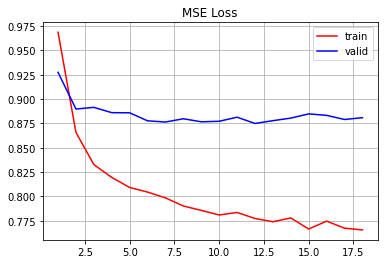


**************************************************

----- densenet -----

**************************************************

Building Model ...

densenet features -> [] -> 1


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.87814 | Valid Loss: 0.86217 | Time: 30.43 seconds
Epoch: 2 | Train Loss: 0.80992 | Valid Loss: 0.84354 | Time: 30.54 seconds
Epoch: 3 | Train Loss: 0.79085 | Valid Loss: 0.83791 | Time: 30.47 seconds
Epoch: 4 | Train Loss: 0.78266 | Valid Loss: 0.83459 | Time: 30.44 seconds
Epoch: 5 | Train Loss: 0.77269 | Valid Loss: 0.84331 | Time: 30.20 seconds
Epoch: 6 | Train Loss: 0.76264 | Valid Loss: 0.83969 | Time: 30.91 seconds
Epoch: 7 | Train Loss: 0.76118 | Valid Loss: 0.84121 | Time: 30.58 seconds
Epoch: 8 | Train Loss: 0.74893 | Valid Loss: 0.84338 | Time: 30.16 seconds
Epoch: 9 | Train Loss: 0.75574 | Valid Loss: 0.83421 | Time: 30.44 seconds
Epoch: 10 | Train Loss: 0.74746 | Valid Loss: 0.84307 | Time: 30.16 seconds
Epoch: 11 | Train Loss: 0.74529 | Valid Loss: 0.83904 | Time: 30.23 seconds
Epoch: 12 | Train Loss: 0.74417 | Valid Loss: 0.84764 

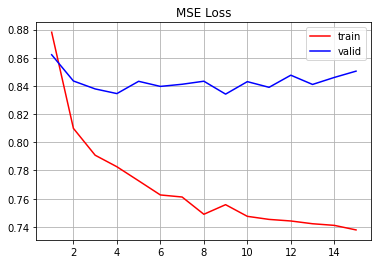


**************************************************

----- resnet -----

**************************************************

Building Model ...

resnet features -> [] -> 1


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.96483 | Valid Loss: 0.88505 | Time: 23.02 seconds
Epoch: 2 | Train Loss: 0.84892 | Valid Loss: 0.88462 | Time: 23.07 seconds
Epoch: 3 | Train Loss: 0.81790 | Valid Loss: 0.87981 | Time: 23.27 seconds
Epoch: 4 | Train Loss: 0.80197 | Valid Loss: 0.87284 | Time: 23.27 seconds
Epoch: 5 | Train Loss: 0.79510 | Valid Loss: 0.87120 | Time: 23.00 seconds
Epoch: 6 | Train Loss: 0.78804 | Valid Loss: 0.86953 | Time: 22.88 seconds
Epoch: 7 | Train Loss: 0.77804 | Valid Loss: 0.86847 | Time: 23.11 seconds
Epoch: 8 | Train Loss: 0.77675 | Valid Loss: 0.87524 | Time: 22.79 seconds
Epoch: 9 | Train Loss: 0.77183 | Valid Loss: 0.85987 | Time: 23.08 seconds
Epoch: 10 | Train Loss: 0.76720 | Valid Loss: 0.85988 | Time: 22.67 seconds
Epoch: 11 | Train Loss: 0.76509 | Valid Loss: 0.85775 | Time: 23.04 seconds
Epoch: 12 | Train Loss: 0.76289 | Valid Loss: 0.87374 

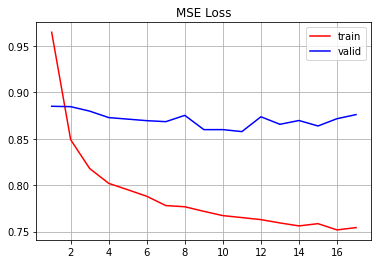


**************************************************

----- vgg -----

**************************************************

Building Model ...

vgg features -> [] -> 1


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.99129 | Valid Loss: 0.90428 | Time: 34.16 seconds
Epoch: 2 | Train Loss: 0.82168 | Valid Loss: 0.89416 | Time: 34.10 seconds
Epoch: 3 | Train Loss: 0.77824 | Valid Loss: 0.89598 | Time: 33.90 seconds
Epoch: 4 | Train Loss: 0.75563 | Valid Loss: 0.89096 | Time: 33.98 seconds
Epoch: 5 | Train Loss: 0.74367 | Valid Loss: 0.88991 | Time: 33.92 seconds
Epoch: 6 | Train Loss: 0.73448 | Valid Loss: 0.89593 | Time: 33.74 seconds
Epoch: 7 | Train Loss: 0.72503 | Valid Loss: 0.89775 | Time: 33.78 seconds
Epoch: 8 | Train Loss: 0.72088 | Valid Loss: 0.91114 | Time: 33.81 seconds
Epoch: 9 | Train Loss: 0.71139 | Valid Loss: 0.90457 | Time: 33.70 seconds
Epoch: 10 | Train Loss: 0.70929 | Valid Loss: 0.90735 | Time: 33.79 seconds

Early Stopping at Epoch 10

**************************************************

Best Validation Loss at Epoch 5

****************

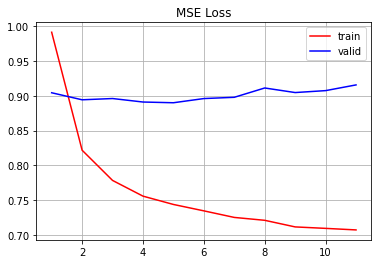

In [10]:
metrics = train()

In [11]:
for i in range(len(metrics)):
    print(metrics[i])

{'Model': 'mobilenet', 'RMSE': 0.9353272723552621}
{'Model': 'densenet', 'RMSE': 0.9133212250859799}
{'Model': 'resnet', 'RMSE': 0.9261500010682043}
{'Model': 'vgg', 'RMSE': 0.9433276582894253}


In [12]:
breaker()
print("Notebook Run Time : {:.2f} minutes".format((time()-notebook_start_time)/60))
breaker()


**************************************************

Notebook Run Time : 26.53 minutes

**************************************************

